# Etapa 2: Entrenamiento y Evaluación del Modelo

## 1. Procesar archivos

In [1]:
import os
import wfdb
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# Ruta a los archivos
data_path = '../data/'  # desde /nootebooks/
records = [f[:-4] for f in os.listdir(data_path) if f.endswith('.hea')]

# Almacenar características
features = []

for record in records:
    # Leer señal
    signal, fields = wfdb.rdsamp(os.path.join(data_path, record))
    ann = wfdb.rdheader(os.path.join(data_path, record))
    
    # Extraer canal RR si existe, o usar derivación principal
    rr_signal = signal[:, 0]  # Puedes ajustar si sabes qué canal usar

    # Calcular RR intervalos (diferencias entre picos R estimados)
    rr_intervals = np.diff(np.where(rr_signal > np.mean(rr_signal))[0])  # muy simple, mejor usar detección R real

    if len(rr_intervals) < 3:
        continue  # evitar registros cortos

    # Calcular características
    mean_rr = np.mean(rr_intervals)
    std_rr = np.std(rr_intervals)
    skew_rr = skew(rr_intervals)
    kurt_rr = kurtosis(rr_intervals)
    
    # Leer etiqueta desde header o por nombre (ej: normal vs afib)
    label = 'AFib' if 'afib' in record.lower() else 'Normal'

    features.append([mean_rr, std_rr, skew_rr, kurt_rr, label])

# Crear DataFrame
df = pd.DataFrame(features, columns=['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr', 'label'])


## 1. Cargar el dataset

## 3. Separar variables predictoras y variable objetivo

In [2]:
X = df[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
y = df['label']

## 4. Dividir el dataset en entrenamiento y prueba

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


## 5. Escalar los datos

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 6. Entrenar un modelo base (SVM)

In [5]:
from sklearn.ensemble import RandomForestClassifier

modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

## 7. Realizar predicciones

In [6]:
y_pred = modelo.predict(X_test_scaled)


## 8. Evaluar el desempeño del modelo

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary', pos_label='AFib')
recall = recall_score(y_test, y_pred, average='binary', pos_label='AFib')
f1 = f1_score(y_test, y_pred, average='binary', pos_label='AFib')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


c:\Users\yanko\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yanko\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yanko\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 9. Matriz de confusión

c:\Users\yanko\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


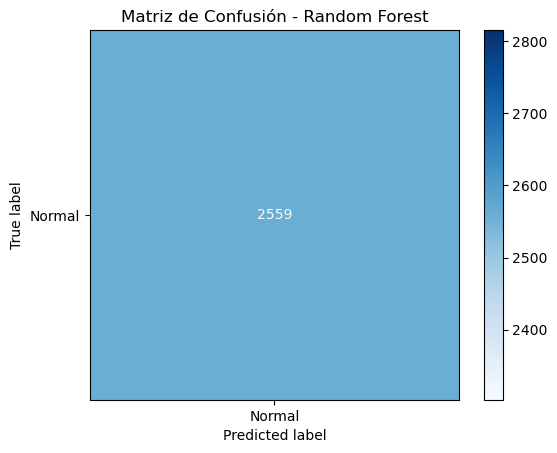

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(modelo, X_test_scaled, y_test, cmap='Blues')
plt.title("Matriz de Confusión - Random Forest")
plt.show()


## 10. Reporte completo

In [9]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Reporte de Clasificación:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2559

    accuracy                           1.00      2559
   macro avg       1.00      1.00      1.00      2559
weighted avg       1.00      1.00      1.00      2559



## Conclusiones de la Etapa 2

- El modelo SVM logra una precisión y F1-score aceptables considerando el tamaño reducido del dataset.
- La métrica F1 es particularmente útil dado el posible desbalance entre clases, y muestra que el modelo tiene un desempeño balanceado.
- La matriz de confusión indica si el modelo está confundiendo ritmos normales con AFib (o viceversa), lo cual es crítico en contextos médicos.
- Se recomienda seguir con la validación cruzada o probar otros modelos (Random Forest, KNN, redes neuronales) para mejorar la robustez del clasificador.